<a href="https://colab.research.google.com/github/KnightHawk15/darknet/blob/master/A1_Ethan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Preliminary reading. Before starting with the code, I did some furthing reading on fine tuning the XGBoost hyperparameters and reading on using `GridSearchCV` and `RandomizedSearchCV`. It may be important to cross reference the location with the average house price.
Imputer

In [0]:
# download data (-q is the quiet mode)
! wget -q https://www.dropbox.com/s/lhb1awpi769bfdr/test.csv?dl=1 -O test.csv
! wget -q https://www.dropbox.com/s/gudb5eunj700s7j/train.csv?dl=1 -O train.csv

In [2]:
import numpy as np 
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from scipy import stats
from scipy.stats import norm, skew #for some statistics

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points


# Train Import
Xy_train = pd.read_csv('train.csv', engine='python')
X_train = Xy_train.drop(columns=['price_rating'])
y_train = Xy_train[['price_rating']]

X_train['security_deposit'] = X_train['security_deposit'].str.replace('$', '')
X_train['security_deposit'] = X_train['security_deposit'].str.replace(',', '')
X_train['security_deposit'] = X_train['security_deposit'].astype(float)

# Test Import
X_test = pd.read_csv('test.csv', engine='python')
X_test['security_deposit'] = X_test['security_deposit'].str.replace('$', '')
X_test['security_deposit'] = X_test['security_deposit'].str.replace(',', '')
X_test['security_deposit'] = X_test['security_deposit'].astype(float)
testing_ids = X_test.Id

print(X_train.shape)
print(X_test.shape)


(7631, 101)
(7632, 101)


#Dataset Analysis + Feature Engineering 🌝


In [0]:
# Shapes and Sizes:
#print('Training size:{}'.format(X_train))
#print('Testing size:{}'.format(X_test))

# Looking at all the data and the percentage of missing values.
master = pd.concat((X_train,X_test)).reset_index(drop=True) # Create a master dataset containing all the data, in the same order.
master_dt = master.dtypes # Get datatypes
master_missing = (master.isnull().sum() / len(master)) * 100 # Compute the percentage of missing data

missing_data = pd.DataFrame({'Missing %' :master_missing,'Data Type' :master_dt}) # Build the df
missing_data = missing_data.sort_values(by = 'Missing %', ascending= False) # Sort the table
# missing_data.head(100) # Print



## Missing Value Handling
*Note: The missing values are assumed*

Of the categories chosen, each included feature's missing values are then handled.
When exploring the dataset certain attributes were very lengthy in text, incomplete with many missing values, not straight foward missing values such as `host_response` or un-important attributes to the problem at hand. I understand "un-importance" is subjective, keeping this in mind I tried to only eliminate only the attributes that over complexified the problem at hand. Technically all of the attributes could have been used but it would involve a very complicated model with language, numeric and image processing capabilities. Furthermore, the complexity of the model does not always lead to a better result.

In [0]:
# Get Sizes of the set for resplitting
n_train = X_train.shape[0]
n_test = X_test.shape[0]

# Remove Features missing all values
master = master.drop(missing_data[missing_data['Missing %'] == 100].index, axis = 1)

useless_features = ['Id','host_response_time','listing_url','last_scraped','name','summary','space','description','experiences_offered','neighborhood_overview','notes','transit','access','interaction','picture_url','host_id','host_url','host_name','host_since','host_location','host_about','host_response_rate','host_thumbnail_url','host_picture_url','host_neighbourhood','host_listings_count','host_verifications','host_has_profile_pic','host_identity_verified','street','neighbourhood','neighbourhood_cleansed','city','state','zipcode','market','smart_location','country_code','country','latitude','longitude','is_location_exact','bed_type','amenities','square_feet','guests_included','extra_people','minimum_nights','maximum_nights','minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm','calendar_updated','has_availability','availability_30','availability_60','availability_90','availability_365','calendar_last_scraped','number_of_reviews_ltm','first_review','last_review','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_value','requires_license','jurisdiction_names','instant_bookable','is_business_travel_ready','cancellation_policy','require_guest_profile_picture','require_guest_phone_verification','calculated_host_listings_count','calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms','reviews_per_month']
master = master.drop(useless_features, axis = 1)
# master.head(3)

### `host_is_superhost`:
boolean, assuming if na then not a superhost (f)

In [0]:
master['host_is_superhost'] = master['host_is_superhost'].fillna('f')

### `host_total_listings_count`:
numerical, same as `host_listings_count`, if na then assume 0

In [0]:
master['host_total_listings_count'] = master['host_total_listings_count'].fillna(0)

### `accommodates, bathrooms, bedrooms, beds,review_scores_location`:
numerical, all missing values are assumed to be the mean value of each attribute.

In [0]:
attribs = ['accommodates','bathrooms','bedrooms','beds','review_scores_location']

for a in attribs:
  master[a] = master[a].fillna(master[a].mean())

###`security_deposit`:
Assumed that there is no deposit ie. $0.00

In [0]:
master['security_deposit'] = master['security_deposit'].fillna(0)

###`number_of_reviews`:
Assumed to be no reviews (0) if na

In [0]:
master['number_of_reviews'] = master['number_of_reviews'].fillna(0)

Check for missing values:

In [10]:
master_missing = (master.isnull().sum() / len(master)) * 100 # Compute the percentage of missing data

missing_data = pd.DataFrame({'Missing %' :master_missing}) # Build the df
missing_data = missing_data.sort_values(by = 'Missing %', ascending= False) # Sort the table
missing_data.head(100) # Print 

master.head(5)

,house_rules,host_is_superhost,host_total_listings_count,property_type,room_type,accommodates,bathrooms,bedrooms,beds,security_deposit,number_of_reviews,review_scores_location
0,- no loud music after 12am - smoking allowed o...,f,13.000,Apartment,Entire home/apt,8,1.000,2.000,4.000,0.000,51,10.000
1,- No Party allowed - No smoking or pets inside...,f,2.000,Apartment,Entire home/apt,3,1.000,1.000,2.000,500.000,3,10.000
2,Les voyageurs doivent respecter les lieux et l...,f,1.000,Apartment,Entire home/apt,2,1.000,2.000,1.000,0.000,6,8.000
3,- Respect the rules of the condo - For securit...,t,1.000,Apartment,Entire home/apt,6,1.000,2.000,2.000,0.000,91,10.000
4,Merci de ne pas faire de bruit après 22h00,f,3.000,Apartment,Entire home/apt,9,1.000,2.000,3.000,300.000,12,10.000
5,NaN,t,1.000,Apartment,Entire home/apt,2,1.000,0.000,2.000,200.000,65,10.000
6,- Pas de fêtes ou d'invités. Il me fera plaisi...,f,8.000,Apartment,Private room,1,1.000,1.000,1.000,0.000,7,10.000
7,JAMAIS DE BRUIT; PAS DE CONSOMMATION DE DROGUE...,t,2.000,House,Private room,1,1.500,1.000,1.000,0.000,5,10.000
8,Les réservations doivent être soumises 48 heur...,t,1.000,Townhouse,Private room,1,1.000,1.000,1.000,400.000,46,10.000
9,NaN,f,1.000,House,Entire home/apt,5,1.000,2.000,3.000,0.000,17,9.000


### Skewness

In [11]:
from scipy.special import boxcox1p

# Skewness
num_fts = master.dtypes[master.dtypes != "object"].index
# print(master[num_fts].head())
# get skewness
skew_fts = master[num_fts].apply(lambda x: skew(x.dropna())).sort_values (ascending = False)

skews = pd.DataFrame({'Skew' : skew_fts})
skews.head(100)

,Skew
bathrooms,14.836
host_total_listings_count,9.407
security_deposit,7.652
number_of_reviews,3.796
beds,2.724
bedrooms,2.534
accommodates,1.878
review_scores_location,-3.525


Woah, looks like we got a major skew problem, time for some box-cox correction 🦕

In [0]:
skew_fts = skews.index
lamdba = 0.15

for f in skew_fts:
  master[f] = boxcox1p(master[f], lamdba)

# master.head(20)

### Discretization:
The encoding of the three categorical attributes: `host_is_superhost`,`property_type`, and `room_type`

### `house_rules`:
Interesting to transform into a boolean, building off stricter vs. looser hosts

In [0]:
master['house_rules'] = master['house_rules'].mask(master['house_rules'].notna(), 1)
master['house_rules'] = master['house_rules'].fillna(0)

In [14]:
from sklearn.preprocessing import LabelEncoder
attribs = ['host_is_superhost','property_type', 'room_type']

for a in attribs:
  le = LabelEncoder()
  le.fit(list(master[a].values))
  master[a] = le.transform(list(master[a].values))

master.head(3)

,house_rules,host_is_superhost,host_total_listings_count,property_type,room_type,accommodates,bathrooms,bedrooms,beds,security_deposit,number_of_reviews,review_scores_location
0,1,0,3.238,1,0,2.603,0.730,1.194,1.820,0.000,5.392,2.886
1,1,0,1.194,1,0,1.541,0.730,0.730,1.194,10.272,1.541,2.886
2,1,0,0.730,1,0,1.194,0.730,1.194,0.730,0.000,2.260,2.603


Rebuild the testing and training sets.

In [15]:
X_train = master[:n_train]
X_test = master[n_train:]

print(X_train.shape)
print(X_test.shape)

Xy_train = X_train.join(y_train)
# Xy_train.head(3)

(7631, 12)
(7632, 12)


## Correlation Exploration

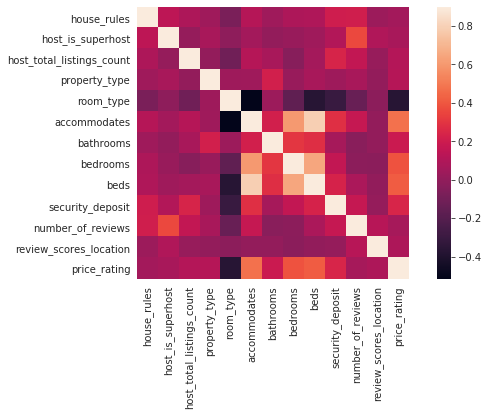

In [16]:
# Correlation Exploration **Including price_rating
corrmat = Xy_train.corr()
plt.subplots(figsize=(10,5))
sns.heatmap(corrmat, vmax = 0.9, square = True)

Looking at the correlation map we can see some obvious correlation between `price_rating` and `accommodates`, `bedrooms`, `beds`, `square_feet` and `guests_included`. Showing their necesesity in the model. But more generally we see the overall high correlation between all of the chosen attributes indicating a strong based for a model. 

#Model 1: XGBoost

Notes on Hyper-Parameters:

https://xgboost.readthedocs.io/en/latest/parameter.html

*   **`learning_rate`:** Shrinkage, lower LR the more robust. 
*   **`gamma`:** Legrangian multiplier, complexity control, penalty for splitting
*   **`max_depth`:** deeper tree -> overfitting
*   **`colsample_bytree`:** fraction of features used by each tree, higher -> overfitting + long computation
*   **`subsample`:** similar to `colsample_bytree` but takes a subset of the data objects, only use for extremely large datasets.
*   **`reg_alpha`:** ***L1*** regularization, pushing sparsity (weights -> 0). Good for logistic regr.
*   **`reg_lambda`:** ***L2*** regularization, pushing smaller weights but does not zero, good for tree-models.
*   **`n_estimators`:** number of trees, always better to have more
*   **`booster`:** choose between:
   *   `gbtree`: regression tree, weaker learner
   *   `gdlinear`: generalized linear regression with L1 and L2 shrinkage. 
   *   `dart`: random dropout, discourages overfitting
*   **`tree_method`:** algorithm used to build trees
*   **`grow_policy`:** controling the addition of new nodes. *only for `tree_method` `hist`*
*   **`predictor`:** predictor type, CPU or GPU



In [17]:
# model training and tuning
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, power_transform
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost.sklearn import XGBClassifier

np.random.seed(5)

# papa regressor
regr = Pipeline(steps=[('regressor',XGBClassifier(
                          objective = 'multi:softmax',
                          seed = 1))])

# Define the grid of hyperparameters to base a search
n_estimators = [50, 100, 200]
max_depth = [10, 20, 30]
# booster = ['gbtree', 'gblinear']
gammas = [0.01, 0.8, 2.1]
# learning_rates = [0.1, 0.01, 0.001]
base_score = [0.25, 0.5, 0.75, 1]
learning_rates = [0.15, 0.20]
min_child_weight = [1, 2, 3, 4]

param_grid = {
    'regressor__n_estimators': n_estimators,
    'regressor__max_depth': max_depth,
    # 'regressor__learning_rate' : learning_rates,
    # 'regressor__min_child_weight' : min_child_weight,
    # 'regressor__booster' : booster,
    # 'regressor__base_score' : base_score,
    'regressor__gamma' : gammas
    }

###### RANDOM SEARCH ######
# random_cv = RandomizedSearchCV(estimator=regr, param_distributions=param_grid, cv=5, 
#                                n_iter=50, scoring = 'accuracy',n_jobs = 4, 
#                                verbose = 5, return_train_score = True, random_state=42)

# random_cv.fit(X_train, y_train)
# print('best score {}'.format(random_cv.best_score_))

###### GRID SEARCH ######
grid_searchXG = GridSearchCV(
    regr, param_grid, cv=5, verbose=5, n_jobs=4, 
    scoring='accuracy')
grid_searchXG.fit(X_train, y_train)
print('best score {}'.format(grid_searchXG.best_score_))

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   26.5s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  4.6min
[Parallel(n_jobs=4)]: Done 135 out of 135 | elapsed: 11.1min finished


best score 0.7120953462403687


In [18]:
print('best score {}'.format(grid_searchXG.best_score_))
print("Learning Rate: ", grid_searchXG.best_estimator_.get_params()["regressor__learning_rate"])
print("Max Depth: ", grid_searchXG.best_estimator_.get_params()["regressor__max_depth"])
print("Booster: ", grid_searchXG.best_estimator_.get_params()["regressor__booster"])
print("Min Child Weight: ", grid_searchXG.best_estimator_.get_params()["regressor__min_child_weight"])
print("Number of Trees: ", grid_searchXG.best_estimator_.get_params()["regressor__n_estimators"])
print("Gamma: ", grid_searchXG.best_estimator_.get_params()["regressor__gamma"])

best score 0.7120953462403687
Learning Rate:  0.1
Max Depth:  10
Booster:  gbtree
Min Child Weight:  1
Number of Trees:  200
Gamma:  2.1


After each run I made several changes to the hyperparameters, here are some of the notable changes and observations:
*   the first interesting result, was no matter the configuration the model always picked a relatively same number of trees.
*   next I noticed the lack of impacked of changing the booster, with no effect.

At this point I found that no changes I made even allowing for very deep trees would increase the accuracy so I revisited the data pre-processing, changing the general imputing to a attribute specific investigation. Additionally, I also adjusted for a large amount of skewness in the data with a cox-box. After this pre-processing switch I continued to tweek the hyperparameters: 
*   I found that a base model, with just a parameter grig of `n_estimators` imediatly provided a 71.6% accuracy, which is pretty awesome. 
*   Noticing that the `best_estimator` is pretty shallow with `max_depth = 3`, I included a variety of deeper trees, to raise the accuracy without making them too deep to overfit. Interestingly enough, the increase in `max_depth` caused a decrease in accuracy to 70.7%. I believe this is due to a lack in regularization, the model making bad splits.
*   Adding regularization via `gamma`, did bring the accurcy back up to 71.2% 



In [0]:
# Prediction & generating the submission file
y_predXG = grid_searchXG.predict(X_test)
pd.DataFrame(
    {'Id': testing_ids, 'price_rating':y_predXG}).to_csv('submission_xgb.csv', index=False)

#Model 2: SVM

In [20]:
from sklearn.svm import SVC
from sklearn import metrics

c = [0.001, 0.01, 1]
gammas = [0.01,0.1,1]

param_grid = {
    'C': c,
    'gamma': gammas
}

grid_searchSVM = GridSearchCV(SVC(kernel = 'rbf'),param_grid, cv = 5)
grid_searchSVM.fit(X_train,y_train)
y_predSVM = grid_search.predict(X_test)

NameError: ignored

In [0]:
# Prediction & generating the submission file
y_pred = grid_searchSVM.predict(X_test)
pd.DataFrame(
    {'Id': testing_ids, 'price_rating':y_predSVM}).to_csv('submission_svm.csv', index=False)

# Questions
1.   Why should we limit the number of trials per day?
   Simply put, the number of trails is limited so we cannot simply overfit to the specifics of the final testing dataset. If we had unlimited trials we could just build a model perfectly suited for the testing set.
2.   Similar to the above answer this is so we cannot over learn the specific patterns of the final evaluation dataset and we can't cater our models to it furthermore overfitting. Furthmore, a better grade would be award to a more robust model, that can perform well on several different datasets.
3.   I chose the XGBoost model for it's strength in flexibilty and customization as well as the simplicity of the model. At the begining I made it more flexible to increase the accuracy then after accuracy balanced out flexibility should decrease.


---

Resources:
*   Class Notes
*   XGBoost Documentation. https://xgboost.readthedocs.io/en/latest/parameter.html
*   Followed the format/thinking of the following Kaggle post. ❤️  https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
*   Datasets and code provided by Prof. Steven Ding thanks
